In [32]:
import torch
from torch.nn import functional as F
from torch import nn 
from torch.optim import Adam
from torch.utils.data import DataLoader 
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np 
import random
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.auto import tqdm


%matplotlib inline 

# set seed for replicable results 
torch.manual_seed(999)
random.seed(10)

In [33]:
# modify this if the dataset is at another path 

image_path = "Dataset"
image_size = (64, 64)
batch_size = 32
latent_size = 100
epoch_restore = 150
checkpoint_path = "Checkpoints/{}epochs.chkpt".format(epoch_restore)

lr = 0.0002
beta1 = 0.5

# adjust if needed, this is how many times we want to train the model over the entire dataset
epochs = 10

# we read the image data and preprocess it 

dataset = ImageFolder(root=image_path,
                           transform=T.Compose([
                               T.Resize(image_size),
                               T.ToTensor(),
                               # normalize to the range [-1, 1]
                               T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))


dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [34]:
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")

In [35]:
# getting a batch from the dataloader 
batch = next(iter(dataloader))

Let's see what we are working with

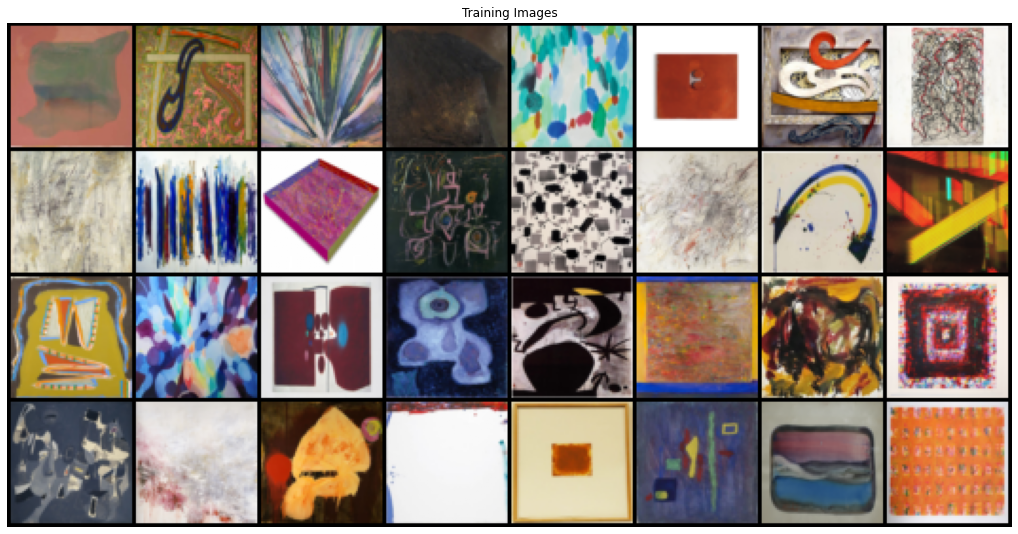

In [36]:
plt.figure(figsize=(18,18))
plt.axis("off")
plt.title("Training Images")

# viewing the training data 
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:batch_size], padding=2, normalize=True).cpu(),(1,2,0)))

# DCGAN Generator Architecture

In [37]:
# custom weights initialization based on the 2015 DCGAN paper 

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

![](https://pytorch.org/tutorials/_images/dcgan_generator.png)

Generator: this will generate images based on a sampled noise 

In [38]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(latent_size, 64*8, 4, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(64*8)
        self.conv2 = nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv3 = nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64*2)
        self.conv4 = nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        x = F.relu(self.bn2(self.conv2(x)), inplace=True)
        x = F.relu(self.bn3(self.conv3(x)), inplace=True)
        x = F.relu(self.bn4(self.conv4(x)), inplace=True)
        return torch.tanh(self.conv5(x))

In [39]:
generator = Generator().to(device)
generator.apply(weights_init)

# calculate the trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(generator)
print("Trainable Parameters:", count_parameters(generator))

Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Trainable Parameters: 3576704


Let's see what we get without training the generator 

In [40]:
untrained_output = generator(torch.randn(1, 100, 1, 1, device=device))
print(untrained_output.shape)

torch.Size([1, 3, 64, 64])


Discriminator: this will decide if a given image is fake or real (from the dataset)

In [41]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(64, 64*2, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64*2)
        self.conv3 = nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(64*4)
        self.conv4 = nn.Conv2d(64*4, 64*8, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64*8)
        self.conv5 = nn.Conv2d(64*8, 1, 4, 1, 0, bias=False)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn1(self.conv2(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv3(x)), negative_slope=0.2, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv4(x)), negative_slope=0.2, inplace=True)
        return torch.sigmoid(self.conv5(x))

In [42]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

print(discriminator)
print("Trainable Parameters:", count_parameters(discriminator))

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)
Trainable Parameters: 2765568


Let's see what we get without training the discriminator 

In [43]:
discriminator(untrained_output).view(-1).detach()

tensor([0.4473], device='cuda:0')

In [44]:
# cross binary entropy, this will be our loss function 
criterion = nn.BCELoss()
sampled_noise  = torch.randn(batch_size, latent_size, 1, 1, device=device)

# real is 1 and fake is 0
real_label = 1
fake_label = 0

generator_optim = Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
discriminator_optim = Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

In [45]:
# restore to the latest checkpoint, comment this out if you would like to train it from scratch
checkpoint = torch.load(checkpoint_path)
generator.load_state_dict(checkpoint['generator_state_dict'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
generator_optim.load_state_dict(checkpoint['generator_optim_state_dict'])
discriminator_optim.load_state_dict(checkpoint['discriminator_optim_state_dict'])

# Training the GAN

In [46]:
# storing data for visualization purposes
generator_loss = []
discriminator_loss = [] 
iters = 0
img_list = []

In [47]:
for epoch in range(epochs):
    for i, data in enumerate(tqdm(dataloader)):
        
        # train the discriminator 
        discriminator.zero_grad()
        real_data = data[0].to(device)
        real_size = real_data.size(0)
        
        # [1, 1, 1, 1...., 1]
        label = torch.ones(real_size, dtype=torch.float32, device=device)
        
        output = discriminator(real_data).view(-1)
        # loss on all-real batch
        error_real_batch = criterion(output, label)
        
        # calculate the derivative wrt parameters
        error_real_batch.backward()
        D_x = output.mean().item()
        
        # generating fake data
        noise = torch.randn(real_size, latent_size, 1, 1, device=device)
        fake_data = generator(noise)
        
        # change the label to [0, 0, 0, 0....., 0]
        label.fill_(fake_label)
        
        # classify all fake batch with discriminator 
        output = discriminator(fake_data.detach()).view(-1)
        error_fake_batch = criterion(output, label)
        error_fake_batch.backward()
        
        # the sum of the discriminator 
        error_discriminator = error_real_batch + error_fake_batch
        discriminator_optim.step()
        
        # train the generator 
        generator.zero_grad()
        # pretend the generated results are real 
        label.fill_(real_label)
        
        output = discriminator(fake_data).view(-1)
        error_generator = criterion(output, label)
        error_generator.backward()
        generator_optim.step()
        
        
        if i % 10 == 0:
            tqdm.write('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, i, len(dataloader),
                     error_discriminator.item(), error_generator.item()))
            
        discriminator_loss.append(error_discriminator.item())
        generator_loss.append(error_generator.item())
        
         # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fakes = generator(sampled_noise).detach().cpu()
            img_list.append(vutils.make_grid(fakes, padding=2, normalize=True))

        iters += 1
    

  2%|▏         | 2/90 [00:07<04:35,  3.13s/it]

[0/10][0/90]	Loss_D: 0.0707	Loss_G: 5.3876


 13%|█▎        | 12/90 [00:09<00:16,  4.61it/s]

[0/10][10/90]	Loss_D: 0.0841	Loss_G: 6.5627


 24%|██▍       | 22/90 [00:13<00:24,  2.75it/s]

[0/10][20/90]	Loss_D: 0.1325	Loss_G: 6.7832


 32%|███▏      | 29/90 [00:16<00:20,  2.94it/s]

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_loss,label="Generator")
plt.plot(discriminator_loss,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=300, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
end_epoch = epoch_restore + epochs
save_file = "Checkpoints/{}epochs.chkpt".format(end_epoch)

torch.save({
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'generator_optim_state_dict' : generator_optim.state_dict(),
            'discriminator_optim_state_dict' : discriminator_optim.state_dict(),}, save_file)

In [ ]:
ani.save("gan-visualization.gif")